In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
plt.style.use('ggplot')
import seaborn as sns
pd.options.display.float_format = '{:,.0f}'.format
from IPython.display import display
import dataframe_image as dfi
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
encoder = OneHotEncoder(sparse_output=False)
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import ensemble
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
import shap
import warnings
import random
warnings.filterwarnings('ignore')
import ipywidgets as widgets
#widgets.IntSlider()

In [2]:
#Import Imputeed Ames Data
Ames = pd.read_csv('Ames_HousePrice_Engineered.csv')

#Update with new Ames Data
Ames_Columns_Numeric = Ames[[
    '1stFlrSF', '2ndFlrSF', '3SsnPorch', 'BedroomAbvGr', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtFullBath', 'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch', 'Fireplaces', 'FullBath',
    'GarageArea', 'GarageCars', 'GarageYrBlt', 'GrLivArea', 'HalfBath', 'KitchenAbvGr',
    'LotArea', 'LotFrontage', 'LowQualFinSF', 'MasVnrArea', 'MiscVal', 'MoSold',
    'OpenPorchSF', 'PoolArea', 'ScreenPorch', 'TotalBsmtSF', 'TotRmsAbvGrd', 'WoodDeckSF',
    'YearBuilt', 'YearRemodAdd', 'YrSold', 'Living_Area_%of_Lot', 'Lot_Frontage_%', 'Home_Age',
    'Yrs_Since_Remodel', '1stFlr_%of_Living_Area', 'Interior_Area_%of_Lot', 'Total_Bathrooms_prorated', 'Kitchens_prorated'
]].apply(pd.to_numeric, errors='coerce')

Ames_Columns_Ordinal = Ames[[
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtQual',
    'Electrical', 'ExterCond', 'ExterQual', 'Fence', 'FireplaceQu', 'Functional',
    'GarageCond', 'GarageFinish', 'GarageQual', 'HeatingQC', 'KitchenQual',
    'LandSlope', 'LotShape', 'OverallCond', 'OverallQual', 'PavedDrive',
    'PoolQC', 'Utilities'
]].apply(pd.to_numeric, errors='coerce')

Ames_Columns_Nominal = Ames[[ 
    'Alley', 'BldgType', 'CentralAir', 'Condition1', 'Condition2',
    'Exterior1st', 'Exterior2nd', 'Foundation', 'GarageType', 'Heating',
    'HouseStyle', 'LandContour', 'LotConfig', 'MasVnrType', 'MiscFeature',
    'MSSubClass', 'MSZoning', 'Neighborhood', 'RoofMatl', 'RoofStyle',
    'SaleCondition', 'SaleType', 'Street'
]].astype('category')

#Combination Table of Numeric & Ordinal Columns
Ames_Columns_Numeric_Ordinal = Ames[
    list(Ames_Columns_Numeric.columns) + list(Ames_Columns_Ordinal.columns)
]
#Combination Table of Nominal & Ordinal Columns
Ames_Columns_Nominal_Ordinal = Ames[
    list(Ames_Columns_Nominal.columns) + list(Ames_Columns_Ordinal.columns)
]

In [3]:
encoder = OneHotEncoder(sparse_output=False)
encoder_nominal = OneHotEncoder(sparse_output=False)
encoder_ordinal = OneHotEncoder(sparse_output=False)
Nominal_cols = Ames_Columns_Nominal.columns
Ordinal_cols = Ames_Columns_Ordinal.columns
Numeric_cols = Ames_Columns_Numeric.columns

#One-Hot Encode Nominal
Ames_Optimal_Nominal_One_Hot = encoder_nominal.fit_transform(Ames[Nominal_cols])
Ames_Optimal_Nominal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Nominal_One_Hot,
    columns=encoder_nominal.get_feature_names_out(Nominal_cols),
    index=Ames.index
)
#DO NOT One-Hot Encode Ordinal (for now)
Ames_Optimal_Ordinal_One_Hot = Ames_Columns_Ordinal #encoder_ordinal.fit_transform(Ames[Ordinal_cols])
Ames_Optimal_Ordinal_One_Hot_df = pd.DataFrame(
    Ames_Optimal_Ordinal_One_Hot,
    #columns=encoder_ordinal.get_feature_names_out(Ordinal_cols),
    index=Ames.index
)
#Merge Nominal & Ordinal Encodings
Ames_Optimal_Categorical_One_Hot = pd.merge(
    Ames_Optimal_Nominal_One_Hot_df,
    Ames_Optimal_Ordinal_One_Hot_df,
    left_index=True,
    right_index=True,
    how='left'
)
#Merge with Numeric Features
Ames_MLR_Optimal_Columns = pd.merge(
    Ames[Numeric_cols],
    Ames_Optimal_Categorical_One_Hot,
    left_index=True,
    right_index=True,
    how='left'
)

In [4]:
Y = Ames['SalePrice']
X = Ames_MLR_Optimal_Columns

#Alternate Version with no One Hot Encoding for HistGradient, LightGBM, and CatBoost
X2 = pd.concat([Ames_Columns_Numeric, Ames_Columns_Ordinal, Ames_Columns_Nominal], axis=1)
for col in Ames_Columns_Nominal.columns:
    X2[col] = X2[col].astype('category')
    Ames[col] = Ames[col].astype('category')

In [5]:
def Plot_HGB_Feature_Importances(model, X=X2, Y=Y, top_n=20, n_permutations=10):
    pd.options.display.float_format = None
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    model_name = type(best_model).__name__

    #Permutation (Feature) Importances
    print(f'Calculating permutation importances for {model_name}...')
    perm_imp = permutation_importance(best_model, X, Y,
                                      n_repeats=n_permutations,
                                      random_state=2, n_jobs=-1)
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': perm_imp.importances_mean
    }).sort_values('Importance', ascending=False)

    #Plot Top Features
    top_features = feature_importance_df.head(top_n)
    y_pos = np.arange(len(top_features))
    plt.figure(figsize=(8, max(6, top_n * 0.4)), dpi=300)
    plt.barh(y_pos, top_features['Importance'], color='teal')
    plt.yticks(y_pos, top_features['Feature'])
    plt.gca().invert_yaxis()
    plt.xlabel('Permutation Importance')
    plt.title(f'{model_name} - Top {top_n} Feature Importances')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.4f}'))
    plt.tight_layout()
    plt.show()

    #Display Data Frame Top Features
    display(feature_importance_df.head(top_n).style.format({'Importance': '{:.4f}'}))

In [6]:
def Plot_Feature_Importances_Only(model, X, top_n=20, max_estimators=20):
    best_model = model.best_estimator_ if hasattr(model, 'best_estimator_') else model
    model_name = type(best_model).__name__
    importances = None

    #Bagged models
    if hasattr(best_model, 'estimators_') and hasattr(best_model.estimators_[0], 'feature_importances_'):
        selected_estimators = best_model.estimators_
        if max_estimators < len(selected_estimators):
            selected_estimators = random.sample(selected_estimators, k=max_estimators)
        importances = np.mean([est.feature_importances_ for est in selected_estimators], axis=0)

    #Boosting models
    elif hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_

    # CatBoost
    elif 'cat' in model_name.lower() and hasattr(best_model, 'get_feature_importance'):
        importances = best_model.get_feature_importance()

    #If error
    if importances is None:
        print(f"{model_name} does not expose feature importances")
        feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.nan})
    else:
        importances = np.array(importances, dtype=float)
        total = np.sum(importances)
        if total != 0 and not np.isnan(total):
            importances /= total  #NORMALIZE to 1
        feature_df = pd.DataFrame({'Feature': X.columns, 'Importance': np.round(importances, 4)})

    #Plot Feature Importances
    feature_df = feature_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    top_df = feature_df.head(top_n).copy()
    y_pos = np.arange(len(top_df))

    plt.figure(figsize=(10, top_n * 0.5), dpi=200)
    plt.barh(y_pos, top_df['Importance'], color='teal')
    plt.yticks(y_pos, top_df['Feature'])
    plt.gca().invert_yaxis()
    plt.xlabel('Feature Importance')
    plt.title(f'{model_name} - Top {top_n} Feature Importances')
    plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.2f}'))
    plt.tight_layout()
    plt.show()

    #Display Table
    display(feature_df.head(top_n).style.format({'Importance': '{:.4f}'}))

In [7]:
#Hist Gradient Boosting Base Model
hgbm = HistGradientBoostingRegressor(random_state=2, verbose=1,
    categorical_features=[
        X2.columns.get_loc(col) for col in Ames_Columns_Nominal.columns]
)
hgbm.fit(X2, Y)

Binning 0.002 GB of training data: 0.032 s
Fitting gradient boosted rounds:
Fit 100 trees in 3.841 s, (3100 total leaves)
Time spent computing histograms: 0.130s
Time spent finding best splits:  0.054s
Time spent applying splits:      0.049s
Time spent predicting:           0.003s


,loss,'squared_error'
,quantile,None
,learning_rate,0.1
,max_iter,100
,max_leaf_nodes,31
,max_depth,None
,min_samples_leaf,20
,l2_regularization,0.0
,max_features,1.0
,max_bins,255
,categorical_features,"[64, 65, ...]"


In [8]:
print('HistGradientBoosting Base Model Score:', float(cross_val_score(hgbm, X2, Y).mean()))

Binning 0.001 GB of training data: 0.019 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.305 s, (3100 total leaves)
Time spent computing histograms: 0.115s
Time spent finding best splits:  0.049s
Time spent applying splits:      0.043s
Time spent predicting:           0.002s
Binning 0.001 GB of training data: 0.037 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.332 s, (3100 total leaves)
Time spent computing histograms: 0.105s
Time spent finding best splits:  0.051s
Time spent applying splits:      0.047s
Time spent predicting:           0.003s
Binning 0.001 GB of training data: 0.033 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.331 s, (3100 total leaves)
Time spent computing histograms: 0.107s
Time spent finding best splits:  0.051s
Time spent applying splits:      0.047s
Time spent predicting:           0.003s
Binning 0.001 GB of training data: 0.035 s
Fitting gradient boosted rounds:
Fit 100 trees in 0.341 s, (3100 total leaves)
Time spent computing histograms:

In [21]:
#Initial Hist Gradient Boosting RandomizedSearchCV for faster estimates
hgbm_param = {
    'learning_rate': [0.09052631578947369],
    'max_leaf_nodes': [6],
    'max_iter': [412],
    'min_samples_leaf': [13],
    'l2_regularization': [.4, 0.5, .625]
}
random_search_hgb = RandomizedSearchCV(
    estimator=hgbm,
    param_distributions=hgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_hgb.fit(X2, Y)
print('Best parameters:', random_search_hgb.best_params_)
print(f'Best CV Score: {random_search_hgb.best_score_:.4f}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Binning 0.002 GB of training data: 0.031 s
Fitting gradient boosted rounds:
Fit 412 trees in 0.278 s, (2472 total leaves)
Time spent computing histograms: 0.065s
Time spent finding best splits:  0.059s
Time spent applying splits:      0.033s
Time spent predicting:           0.007s
Best parameters: {'min_samples_leaf': 13, 'max_leaf_nodes': 6, 'max_iter': 412, 'learning_rate': 0.09052631578947369, 'l2_regularization': 0.5}
Best CV Score: 0.9272


Calculating permutation importances for HistGradientBoostingRegressor...


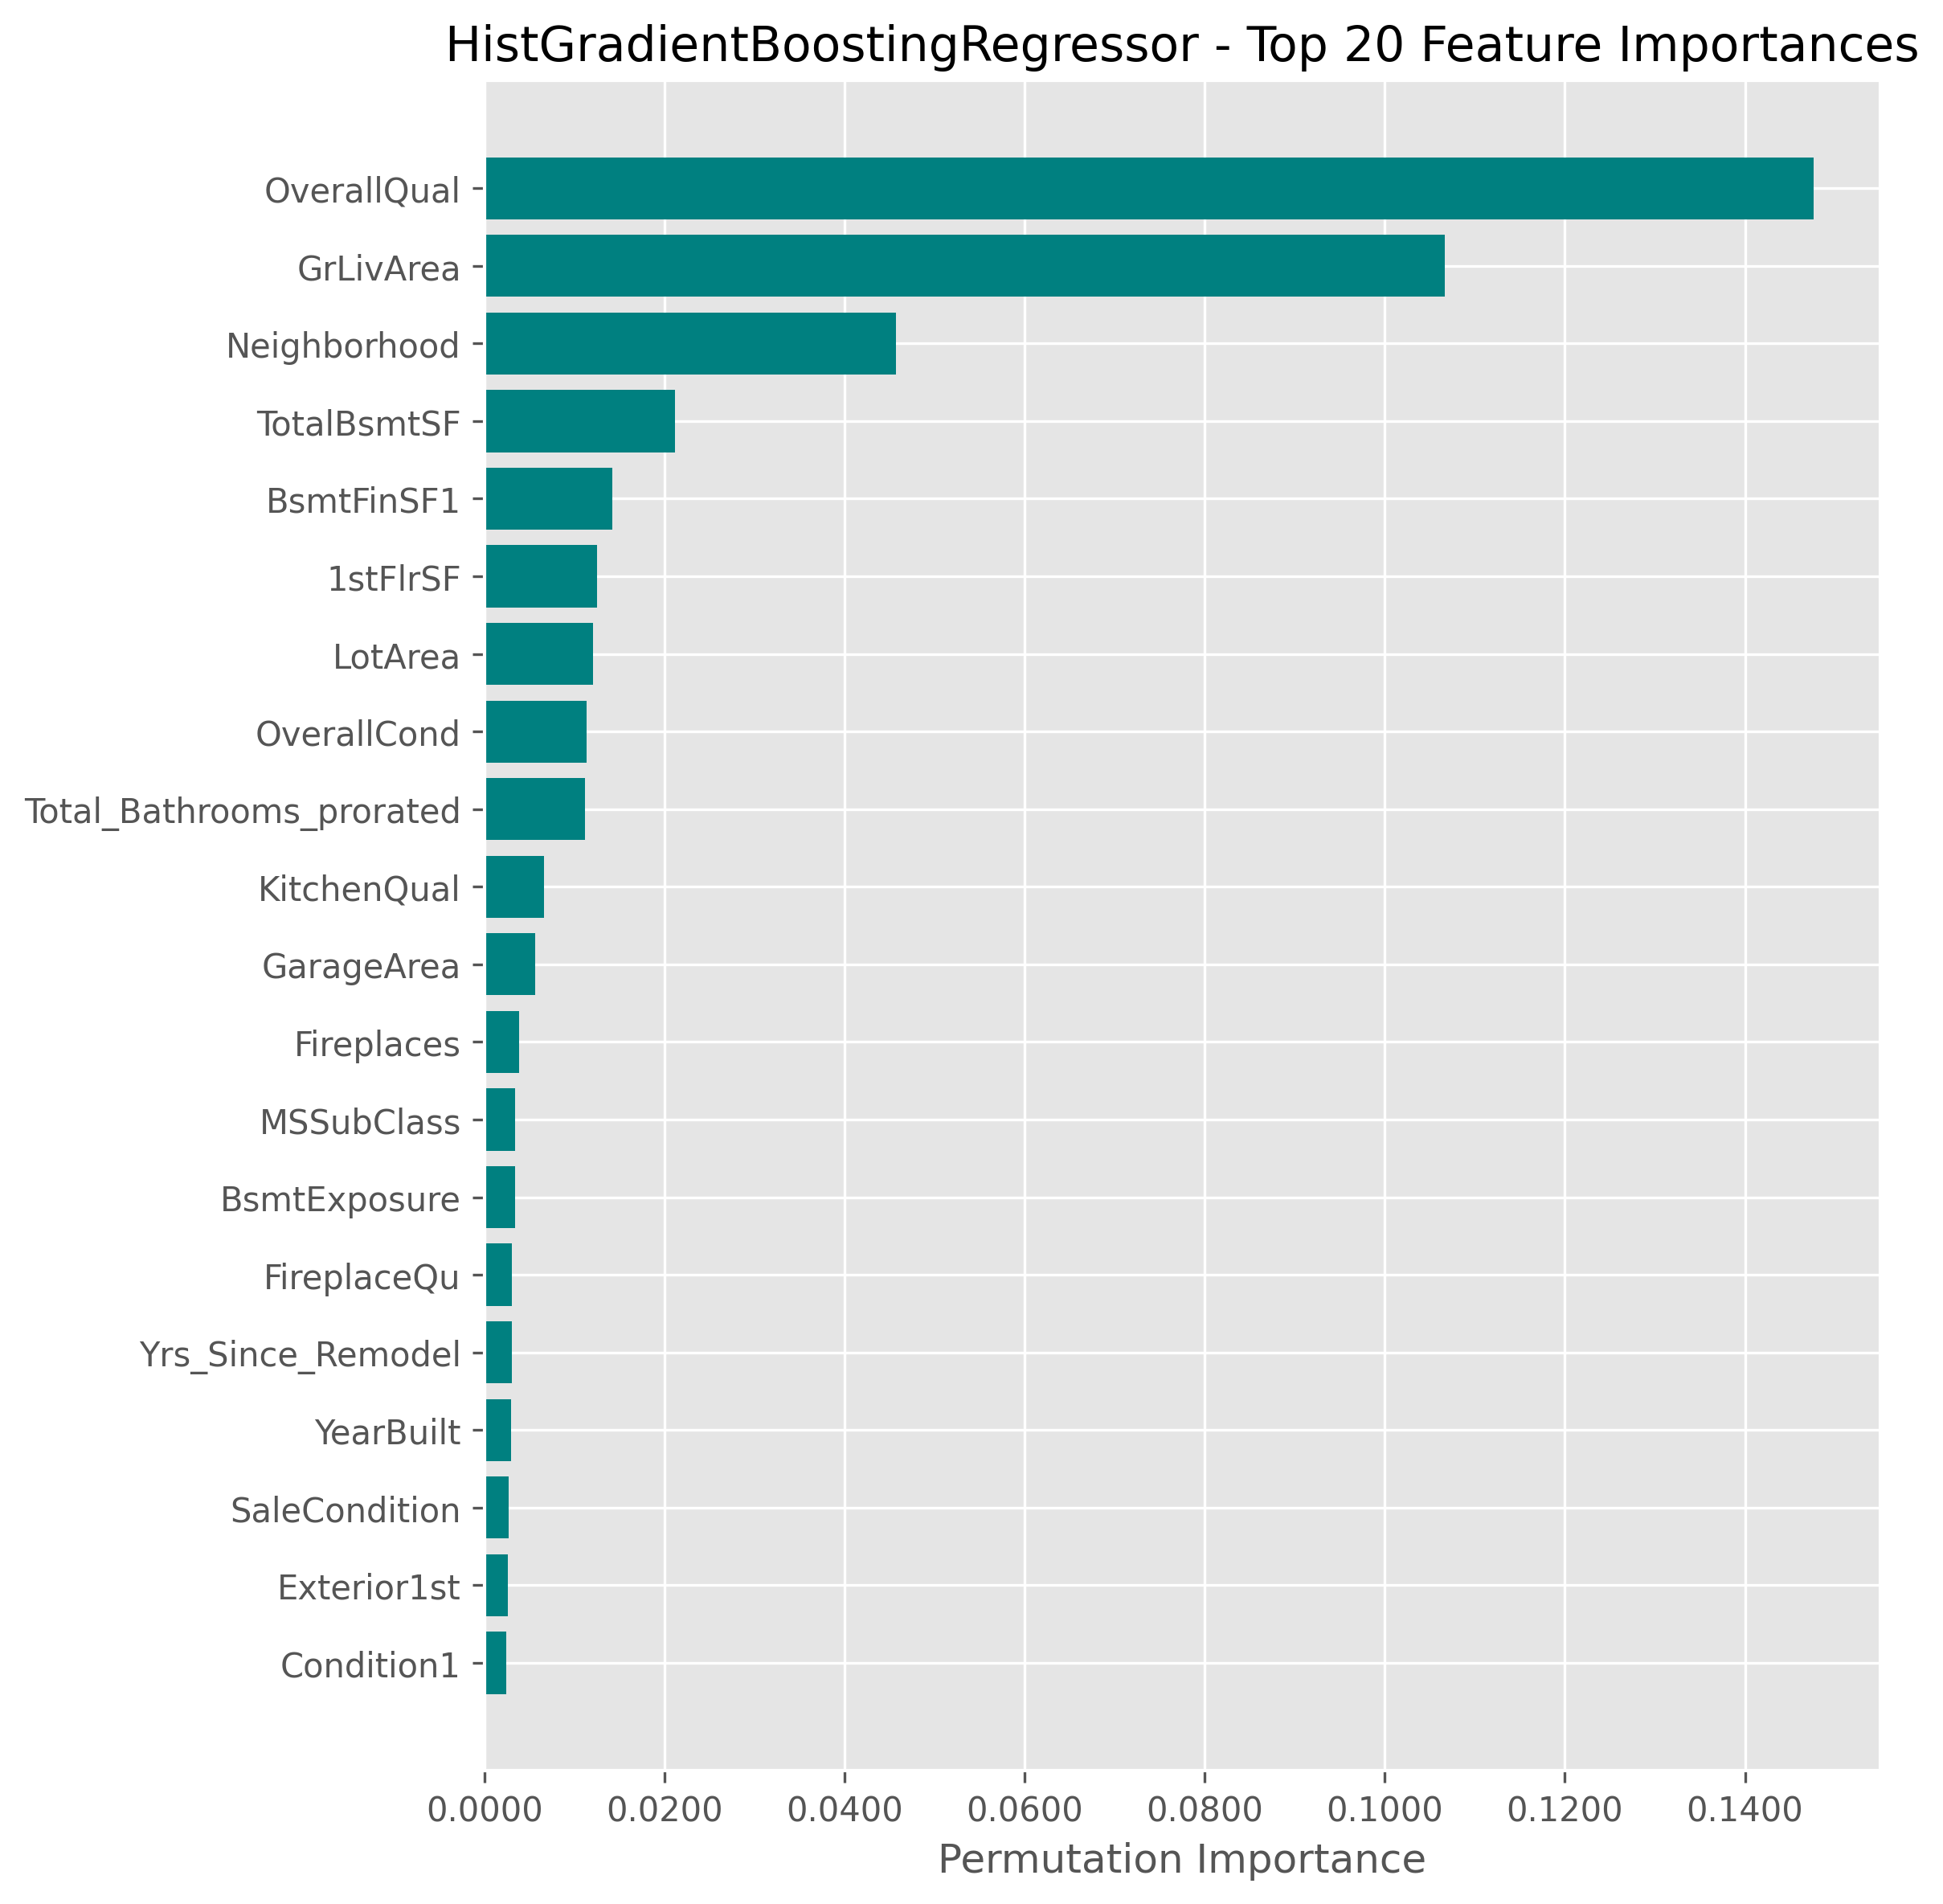

,Feature,Importance
60,OverallQual,0.1477
15,GrLivArea,0.1067
81,Neighborhood,0.0457
27,TotalBsmtSF,0.0211
4,BsmtFinSF1,0.0142
0,1stFlrSF,0.0125
18,LotArea,0.0121
59,OverallCond,0.0114
39,Total_Bathrooms_prorated,0.0112
56,KitchenQual,0.0066


In [22]:
#Hist Gradient Boosting Regressor Feature Importances & SHAP values
Plot_HGB_Feature_Importances(random_search_hgb, X2)

In [23]:
#Base XGBoost Model
xgbm = XGBRegressor(random_state=2, enable_categorical=True, n_jobs=-1, verbosity=1, booster='gbtree')
xgbm.fit(X2, Y)

,objective,'reg:squarederror'
,base_score,None
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [24]:
print('XGBoost Base Model Score:', float(cross_val_score(xgbm, X2, Y).mean()))

XGBoost Base Model Score: 0.9014463901519776


In [25]:
#Initial XGBoost RandomizedSearchCV for faster estimates
xgbm_param = {
    'learning_rate': np.linspace(0.01, 0.1, 11),
    'subsample': np.linspace(0.7, 1, 4),
    'colsample_bytree': np.linspace(0.7, 1, 4),
    'max_depth': range(2, 11),
    'n_estimators': range(210, 260),
    'min_child_weight': range(1, 11),
    'gamma': [0, 0.1, 0.2],
    'reg_lambda': np.linspace(0, 1, 5),
    'reg_alpha': np.linspace(0, 1, 5),
}
random_search_xgbm = RandomizedSearchCV(
    estimator=xgbm,
    param_distributions=xgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_xgbm.fit(X2, Y)
print('Best parameters:', random_search_xgbm.best_params_)
print(f'Best CV Score: {random_search_xgbm.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': np.float64(1.0), 'reg_lambda': np.float64(0.25), 'reg_alpha': np.float64(0.75), 'n_estimators': 249, 'min_child_weight': 9, 'max_depth': 6, 'learning_rate': np.float64(0.037000000000000005), 'gamma': 0.1, 'colsample_bytree': np.float64(0.7)}
Best CV Score: 0.9244


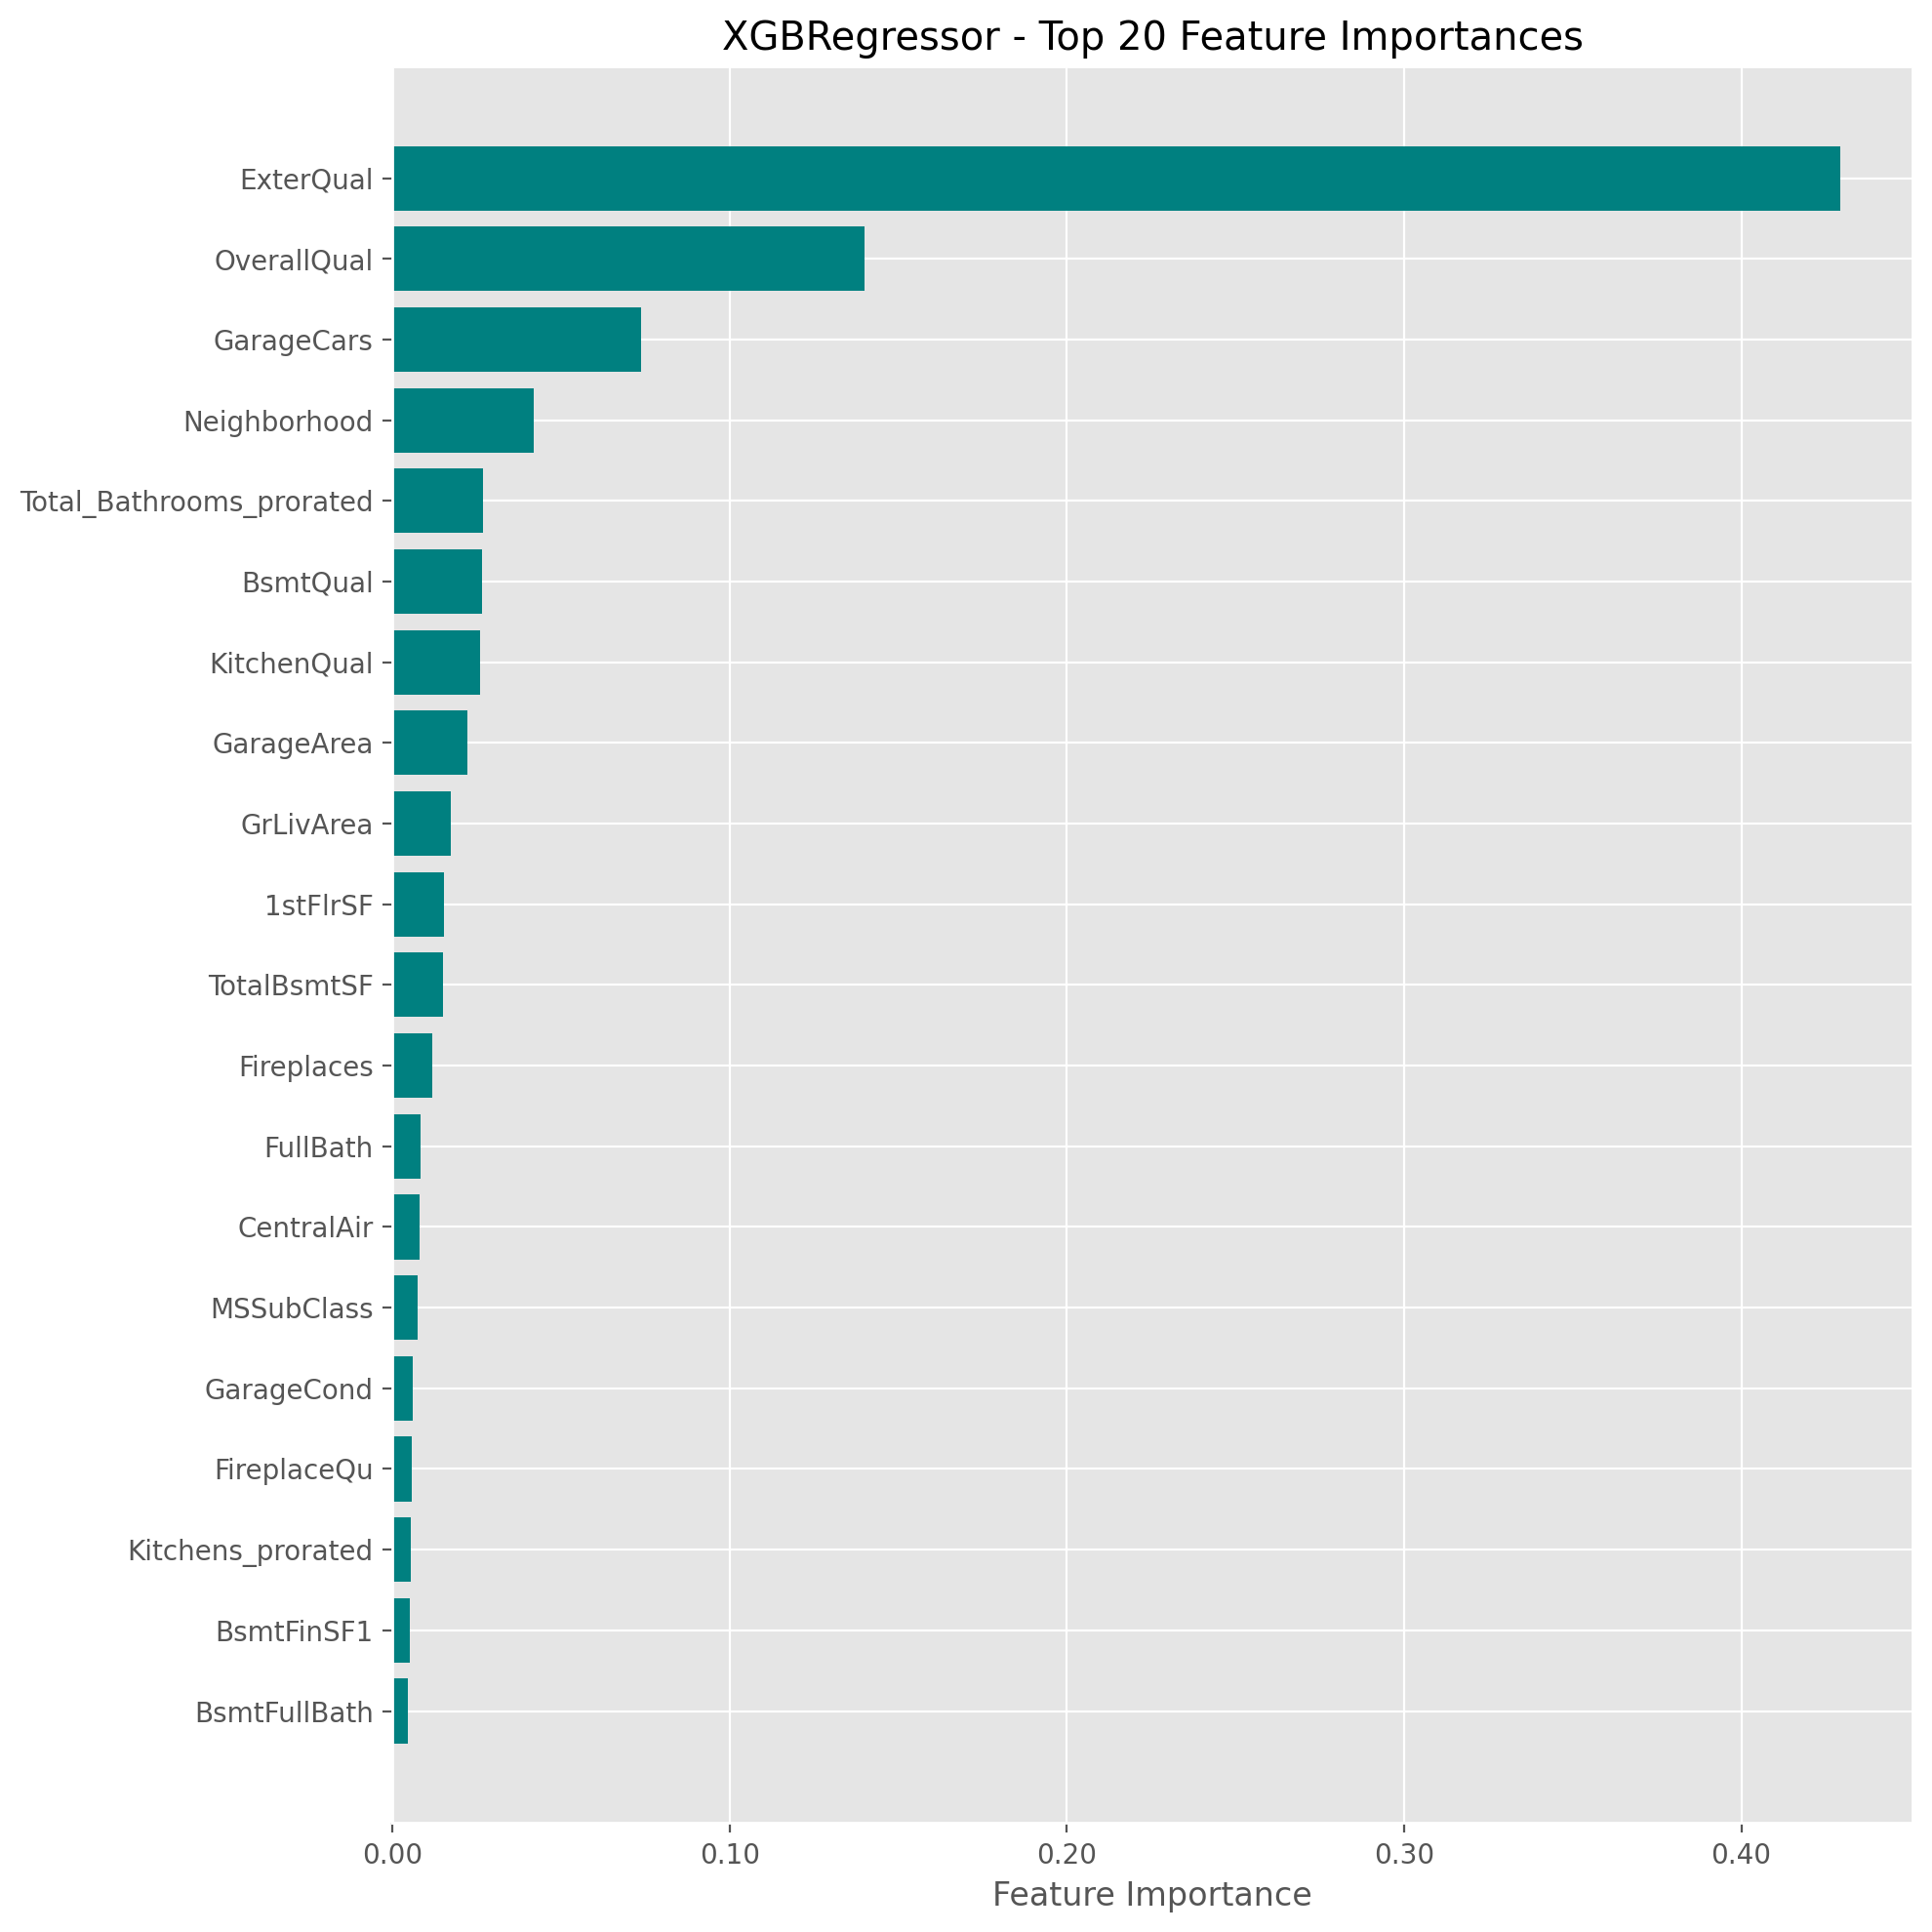

,Feature,Importance
0,ExterQual,0.4293
1,OverallQual,0.1401
2,GarageCars,0.0738
3,Neighborhood,0.0418
4,Total_Bathrooms_prorated,0.0270
5,BsmtQual,0.0266
6,KitchenQual,0.0260
7,GarageArea,0.0222
8,GrLivArea,0.0173
9,1stFlrSF,0.0153


In [26]:
#XGBoost Feature Importances & SHAP values
Plot_Feature_Importances_Only(random_search_xgbm, X2)

In [31]:
#Base LightGBM Model
lgbm = LGBMRegressor(random_state=2, verbose=1, n_jobs=-1)
lgbm.fit(X2, Y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5099
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 83
[LightGBM] [Info] Start training from score 178053.442420


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [32]:
print('LightGBM Base Model Score:', float(cross_val_score(lgbm, X2, Y).mean()))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5004
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 83
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5018
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 83
[LightGBM] [Info] Start training from score 177182.857974
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5009
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 83
[LightGBM] [Info] St

In [37]:
#Initial LightGBM RandomizedSearchCV for faster estimates
lgbm_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [1, 50, 99],
    'n_estimators': [100, 125, 150, 175, 200],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5]
}
random_search_lgbm = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=lgbm_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_lgbm.fit(X2, Y)
print('Best parameters:', random_search_lgbm.best_params_)
print(f'Best CV Score: {random_search_lgbm.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5101
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 84
[LightGBM] [Info] Start training from score 178053.442420
Best parameters: {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 100, 'min_child_samples': 10, 'max_depth': 50, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best CV Score: 0.9160


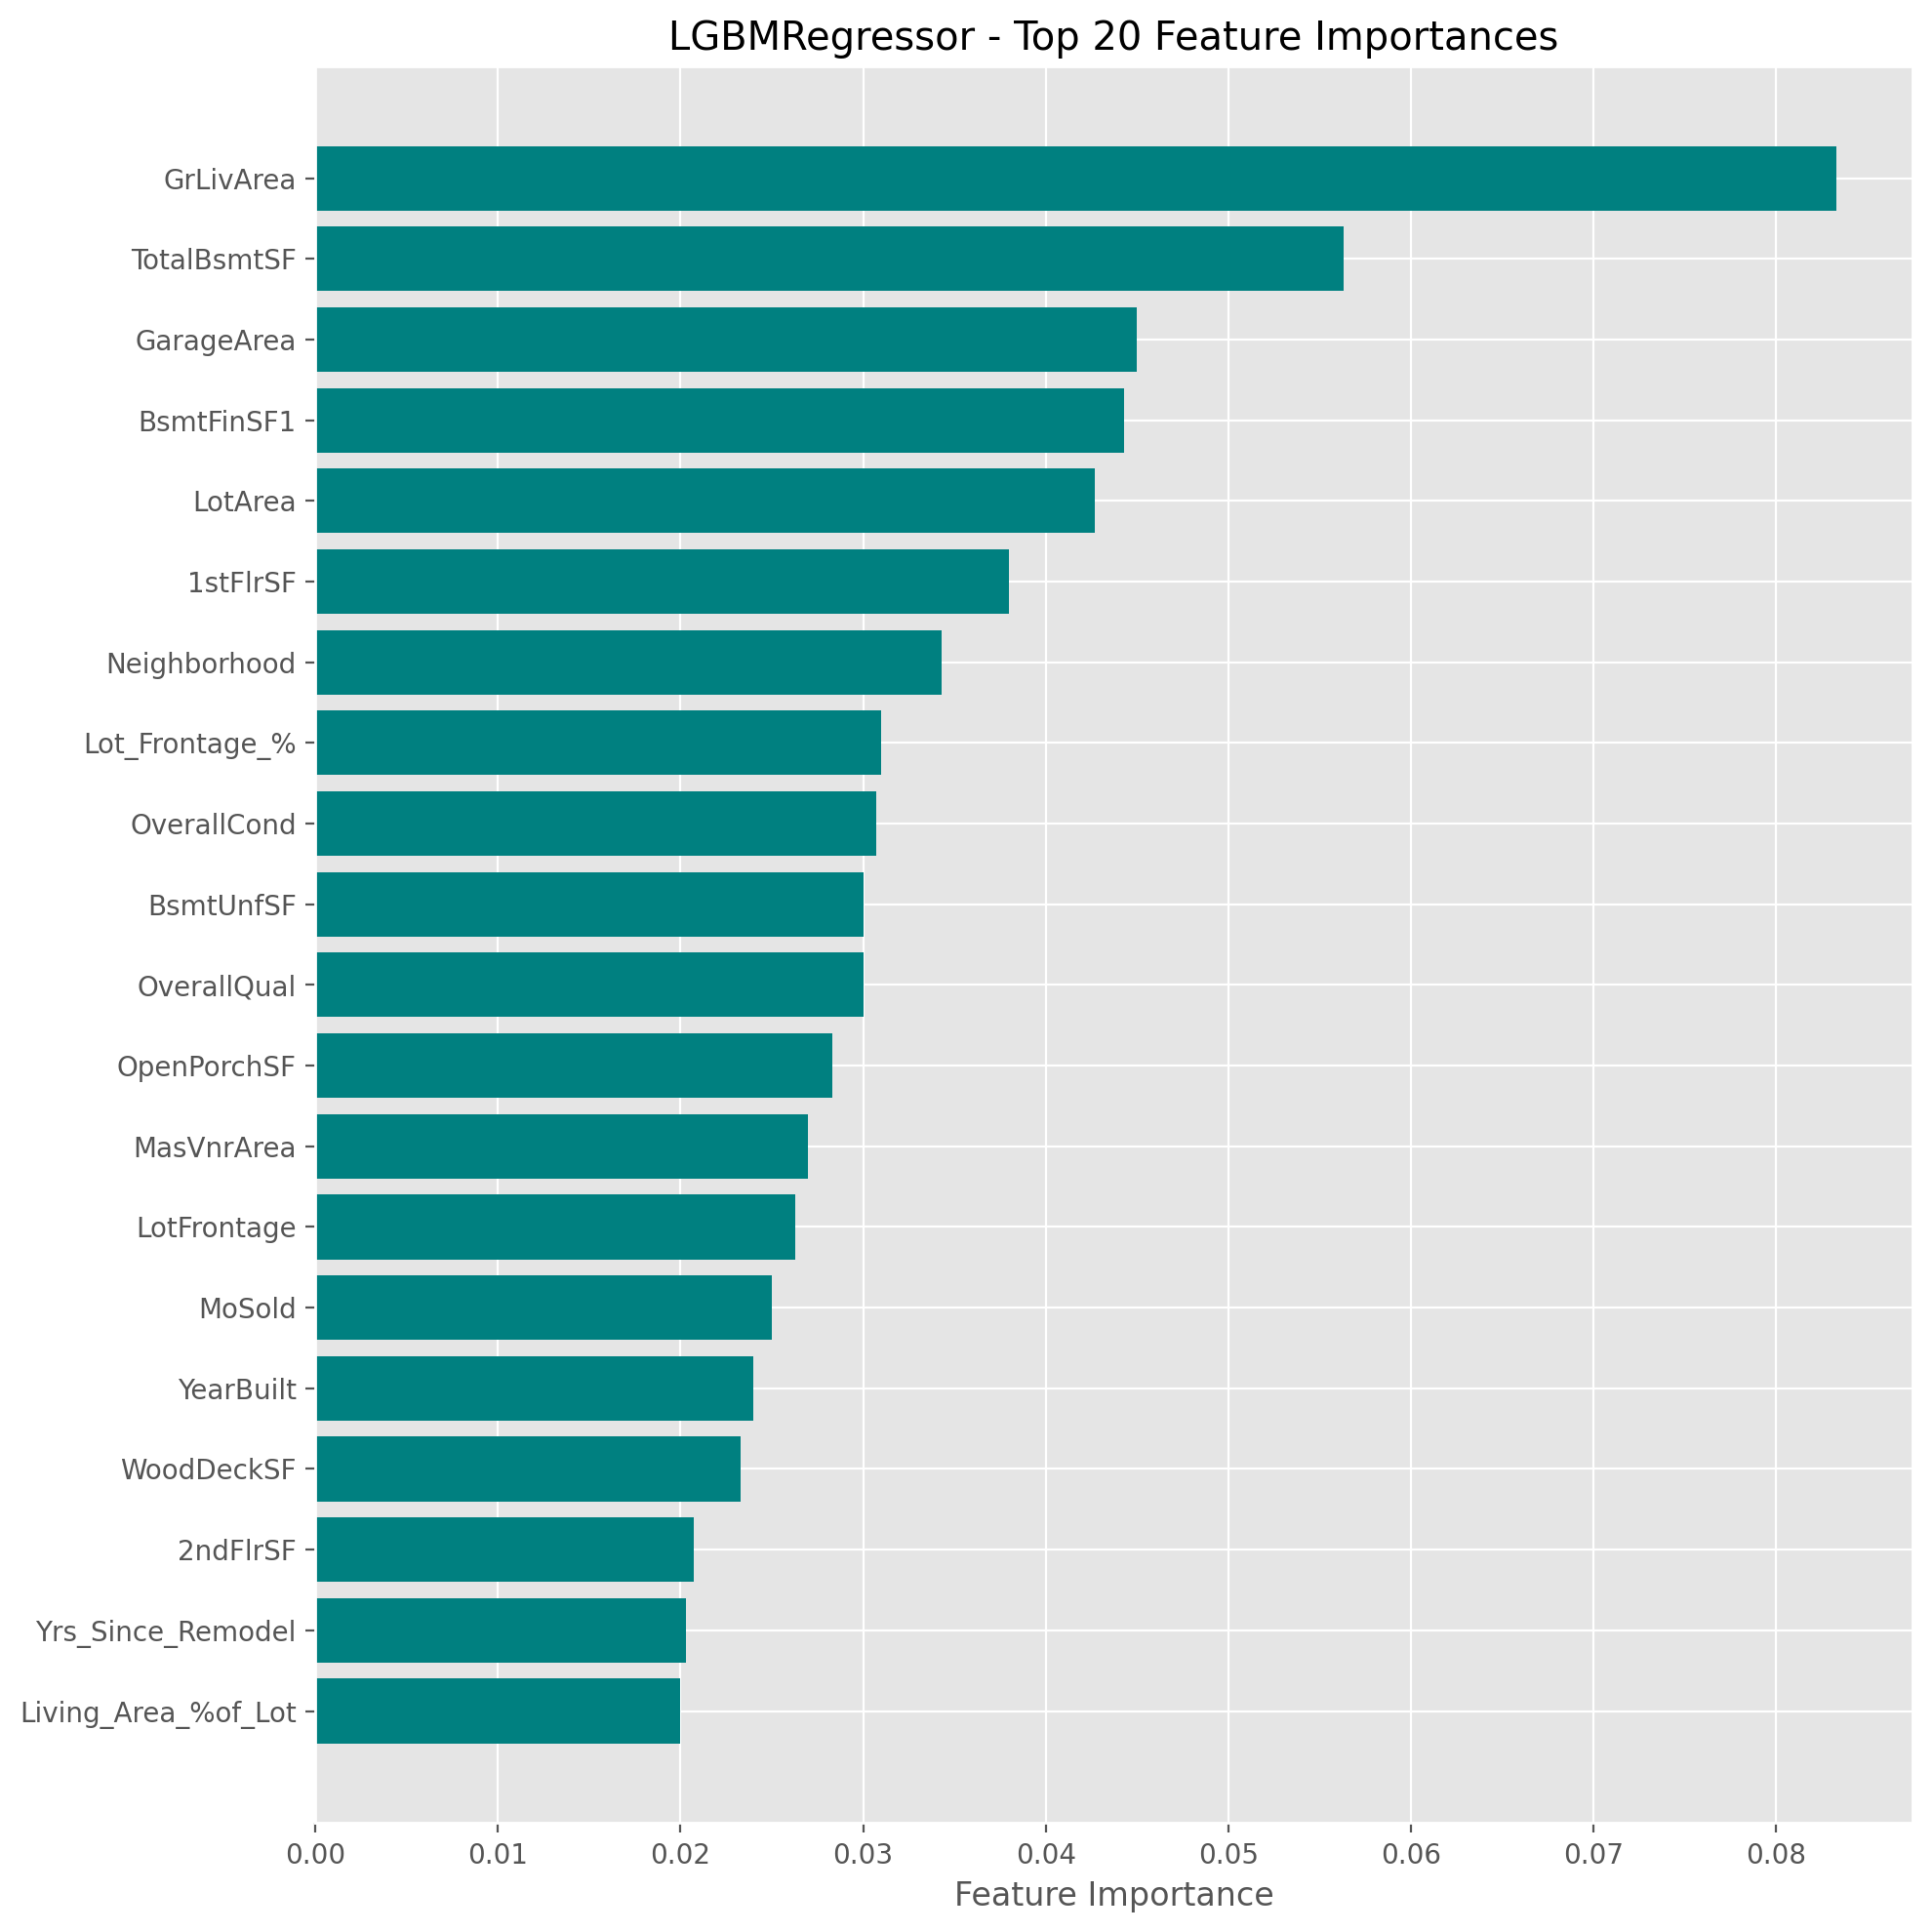

,Feature,Importance
0,GrLivArea,0.0833
1,TotalBsmtSF,0.0563
2,GarageArea,0.0450
3,BsmtFinSF1,0.0443
4,LotArea,0.0427
5,1stFlrSF,0.0380
6,Neighborhood,0.0343
7,Lot_Frontage_%,0.0310
8,OverallCond,0.0307
9,BsmtUnfSF,0.0300


In [38]:
#LightGBM Feature Importances & SHAP values
Plot_Feature_Importances_Only(random_search_lgbm, X2)

In [39]:
lgbm_GOSS = LGBMRegressor(random_state=2, verbose=1, n_jobs=-1, boosting_type='goss')
lgbm_GOSS.fit(X2, Y)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5099
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 83
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 178053.442420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

,boosting_type,'goss'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [40]:
print('LightGBM GOSS Base Model Score:', float(cross_val_score(lgbm_GOSS, X2, Y).mean()))

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5004
[LightGBM] [Info] Number of data points in the train set: 2063, number of used features: 83
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 177061.364033
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [42]:
#Initial LightGBM GOSS RandomizedSearchCV for faster estimates
lgbm_GOSS_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_samples': [10, 20, 30],
    'num_leaves': [15, 31, 63, 127],
    'max_depth': [1, 50, 99],
    'n_estimators': [50, 100, 150, 200, 250],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5]
}
random_search_lgbm_GOSS = RandomizedSearchCV(
    estimator=lgbm_GOSS,
    param_distributions=lgbm_GOSS_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_lgbm_GOSS.fit(X2, Y)
print('Best parameters:', random_search_lgbm_GOSS.best_params_)
print(f'Best CV Score: {random_search_lgbm_GOSS.best_score_:.4f}')

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5101
[LightGBM] [Info] Number of data points in the train set: 2579, number of used features: 84
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 178053.442420
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

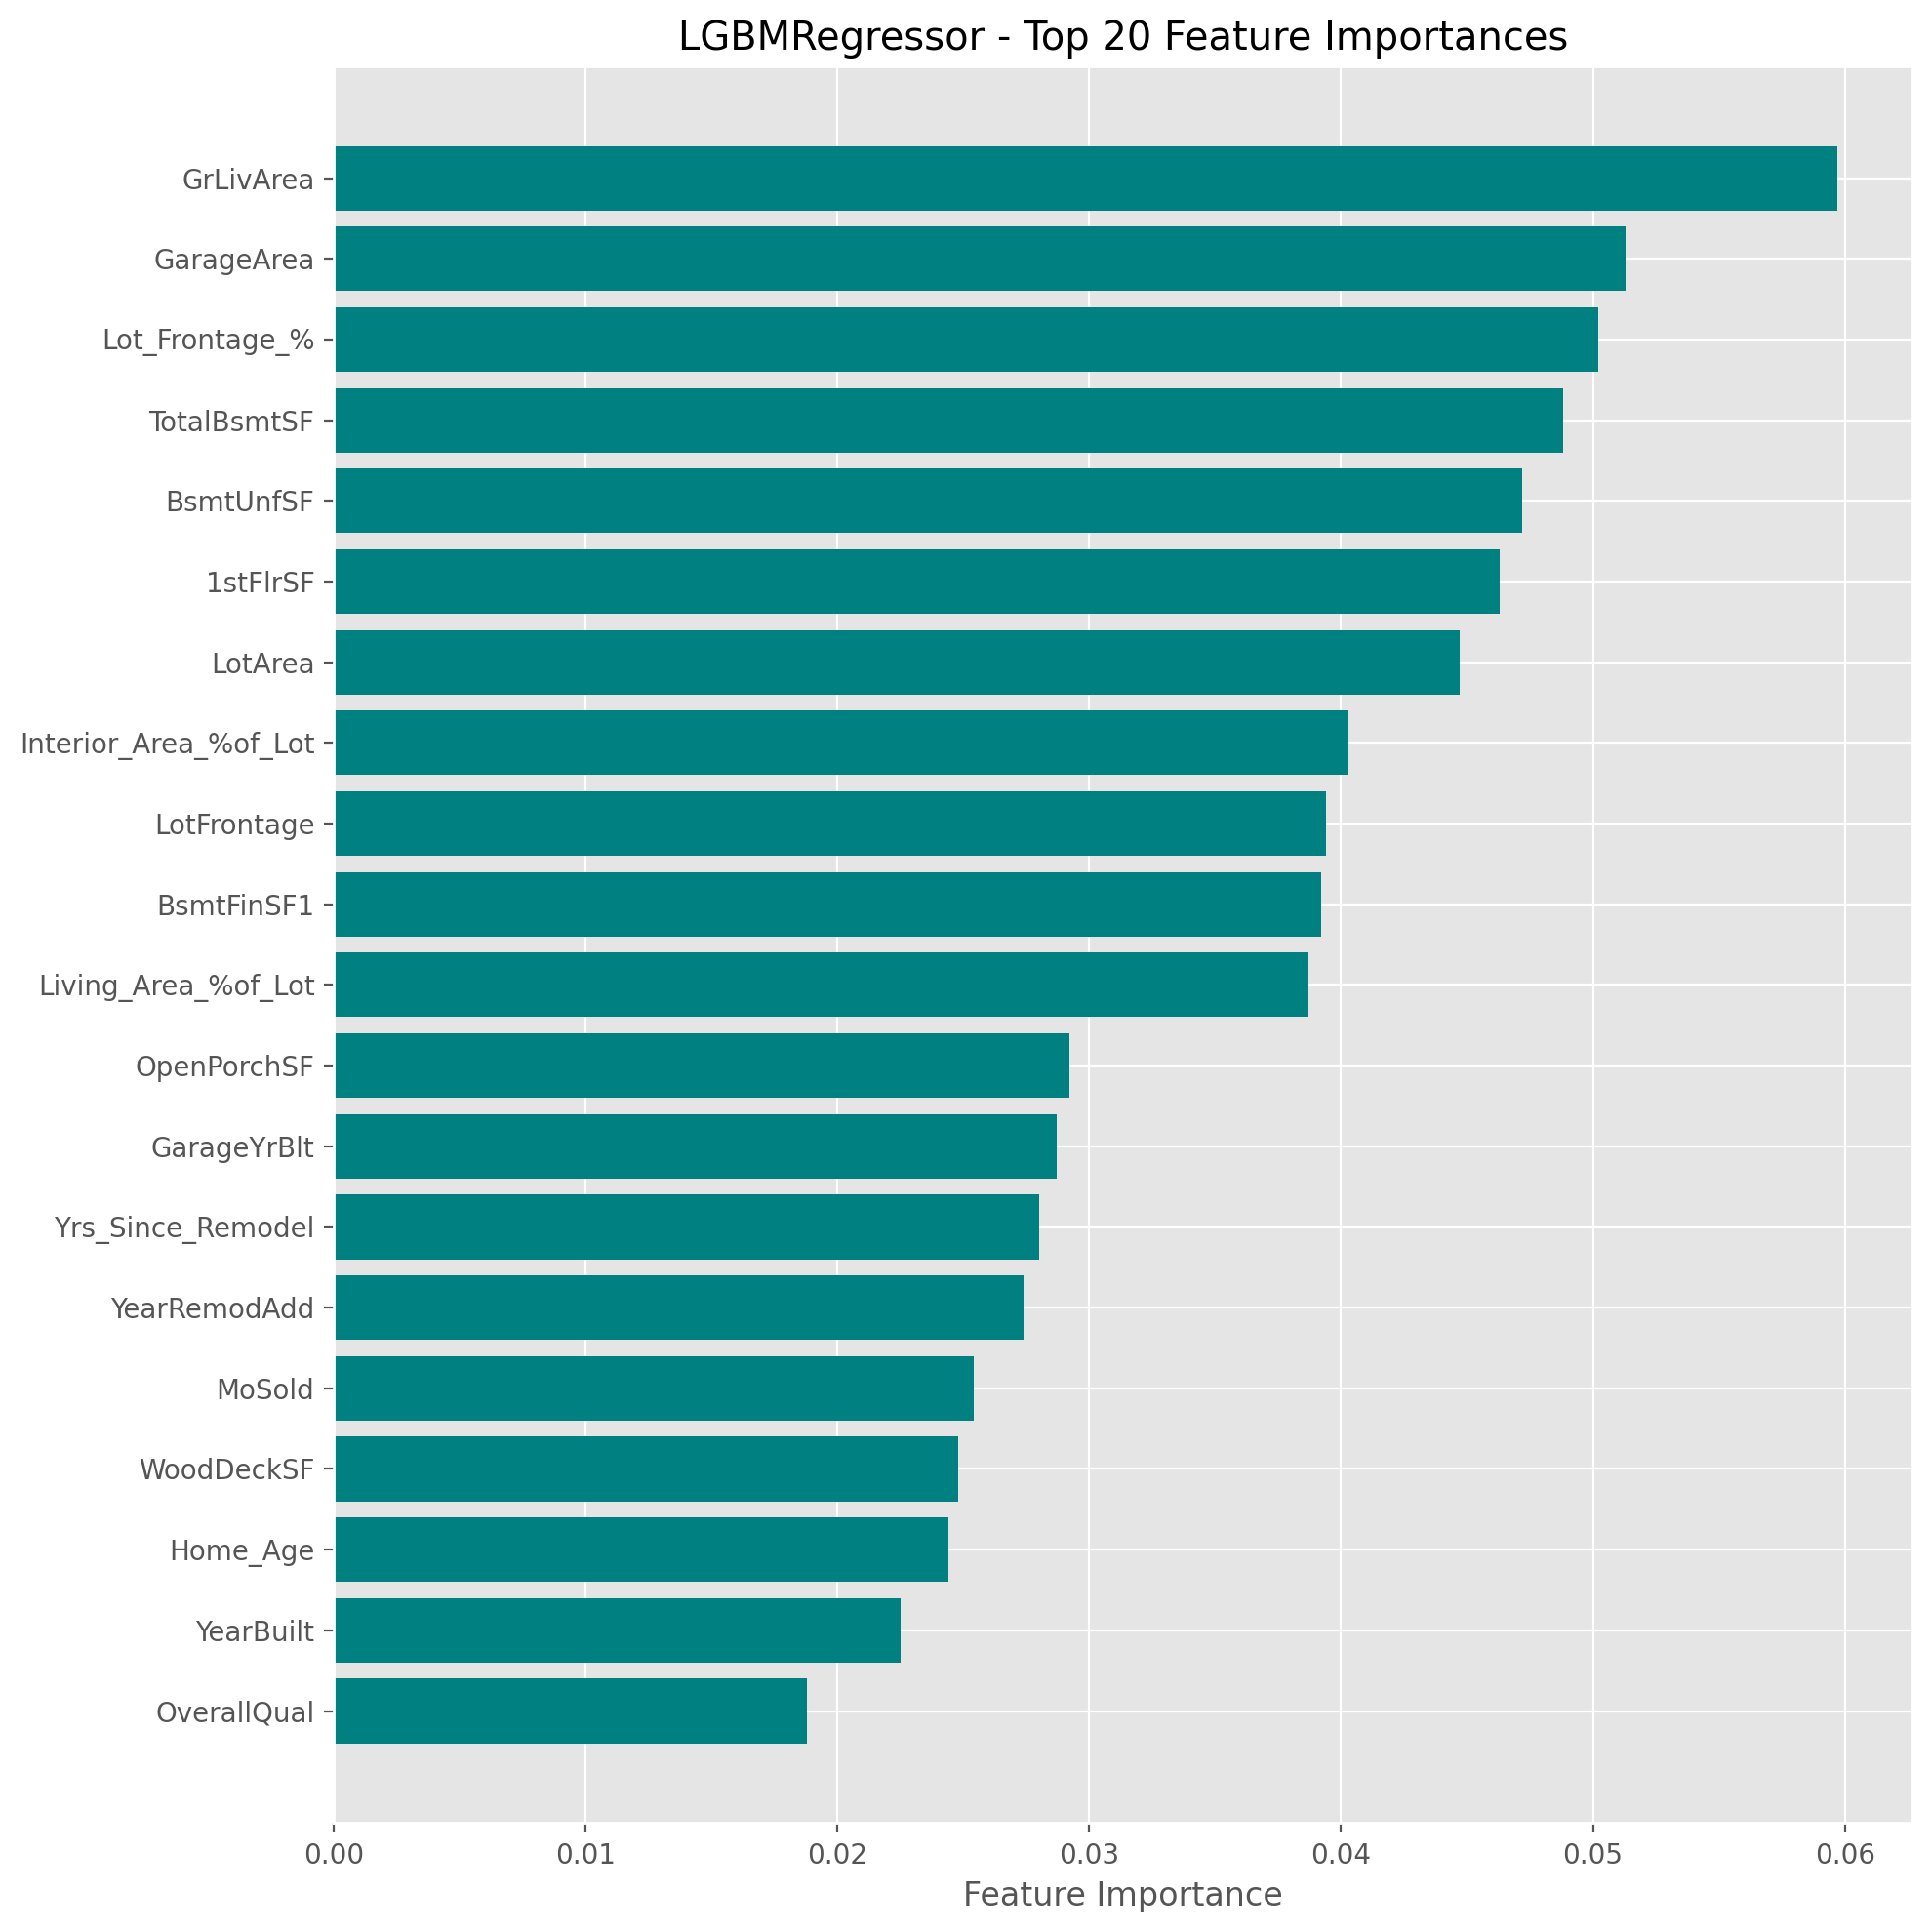

,Feature,Importance
0,GrLivArea,0.0597
1,GarageArea,0.0513
2,Lot_Frontage_%,0.0502
3,TotalBsmtSF,0.0488
4,BsmtUnfSF,0.0472
5,1stFlrSF,0.0463
6,LotArea,0.0447
7,Interior_Area_%of_Lot,0.0403
8,LotFrontage,0.0394
9,BsmtFinSF1,0.0392


In [43]:
#LightGBM GOSS Feature Importances & SHAP values
Plot_Feature_Importances_Only(random_search_lgbm_GOSS, X2)

In [44]:
cat_boost = CatBoostRegressor(cat_features=[col for col in Ames_Columns_Nominal.columns], random_state=2, verbose=0, thread_count=-1)
cat_boost.fit(X2, Y)

In [45]:
print('CatBoost Base Model Score:', float(cross_val_score(cat_boost, X2, Y).mean()))

CatBoost Base Model Score: 0.9295033065232812


In [ ]:
#Initial CatBoost RandomizedSearchCV for faster estimates
'''
cat_boost_param = {
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bylevel': [0.7, 0.8, 0.9, 1.0],
    'min_data_in_leaf': [10, 20, 30],
    'depth': [4, 6, 8, 10],
    'iterations': range(150, 250),
    'l2_leaf_reg': [0.0, 0.1, 0.5, 1.0]
}
random_search_cat = RandomizedSearchCV(
    estimator=cat_boost,
    param_distributions=cat_boost_param,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=2,
    verbose=1
)
random_search_cat.fit(X2, Y)
print('Best parameters:', random_search_cat.best_params_)
print(f'Best CV Score: {random_search_cat.best_score_:.4f}')
'''

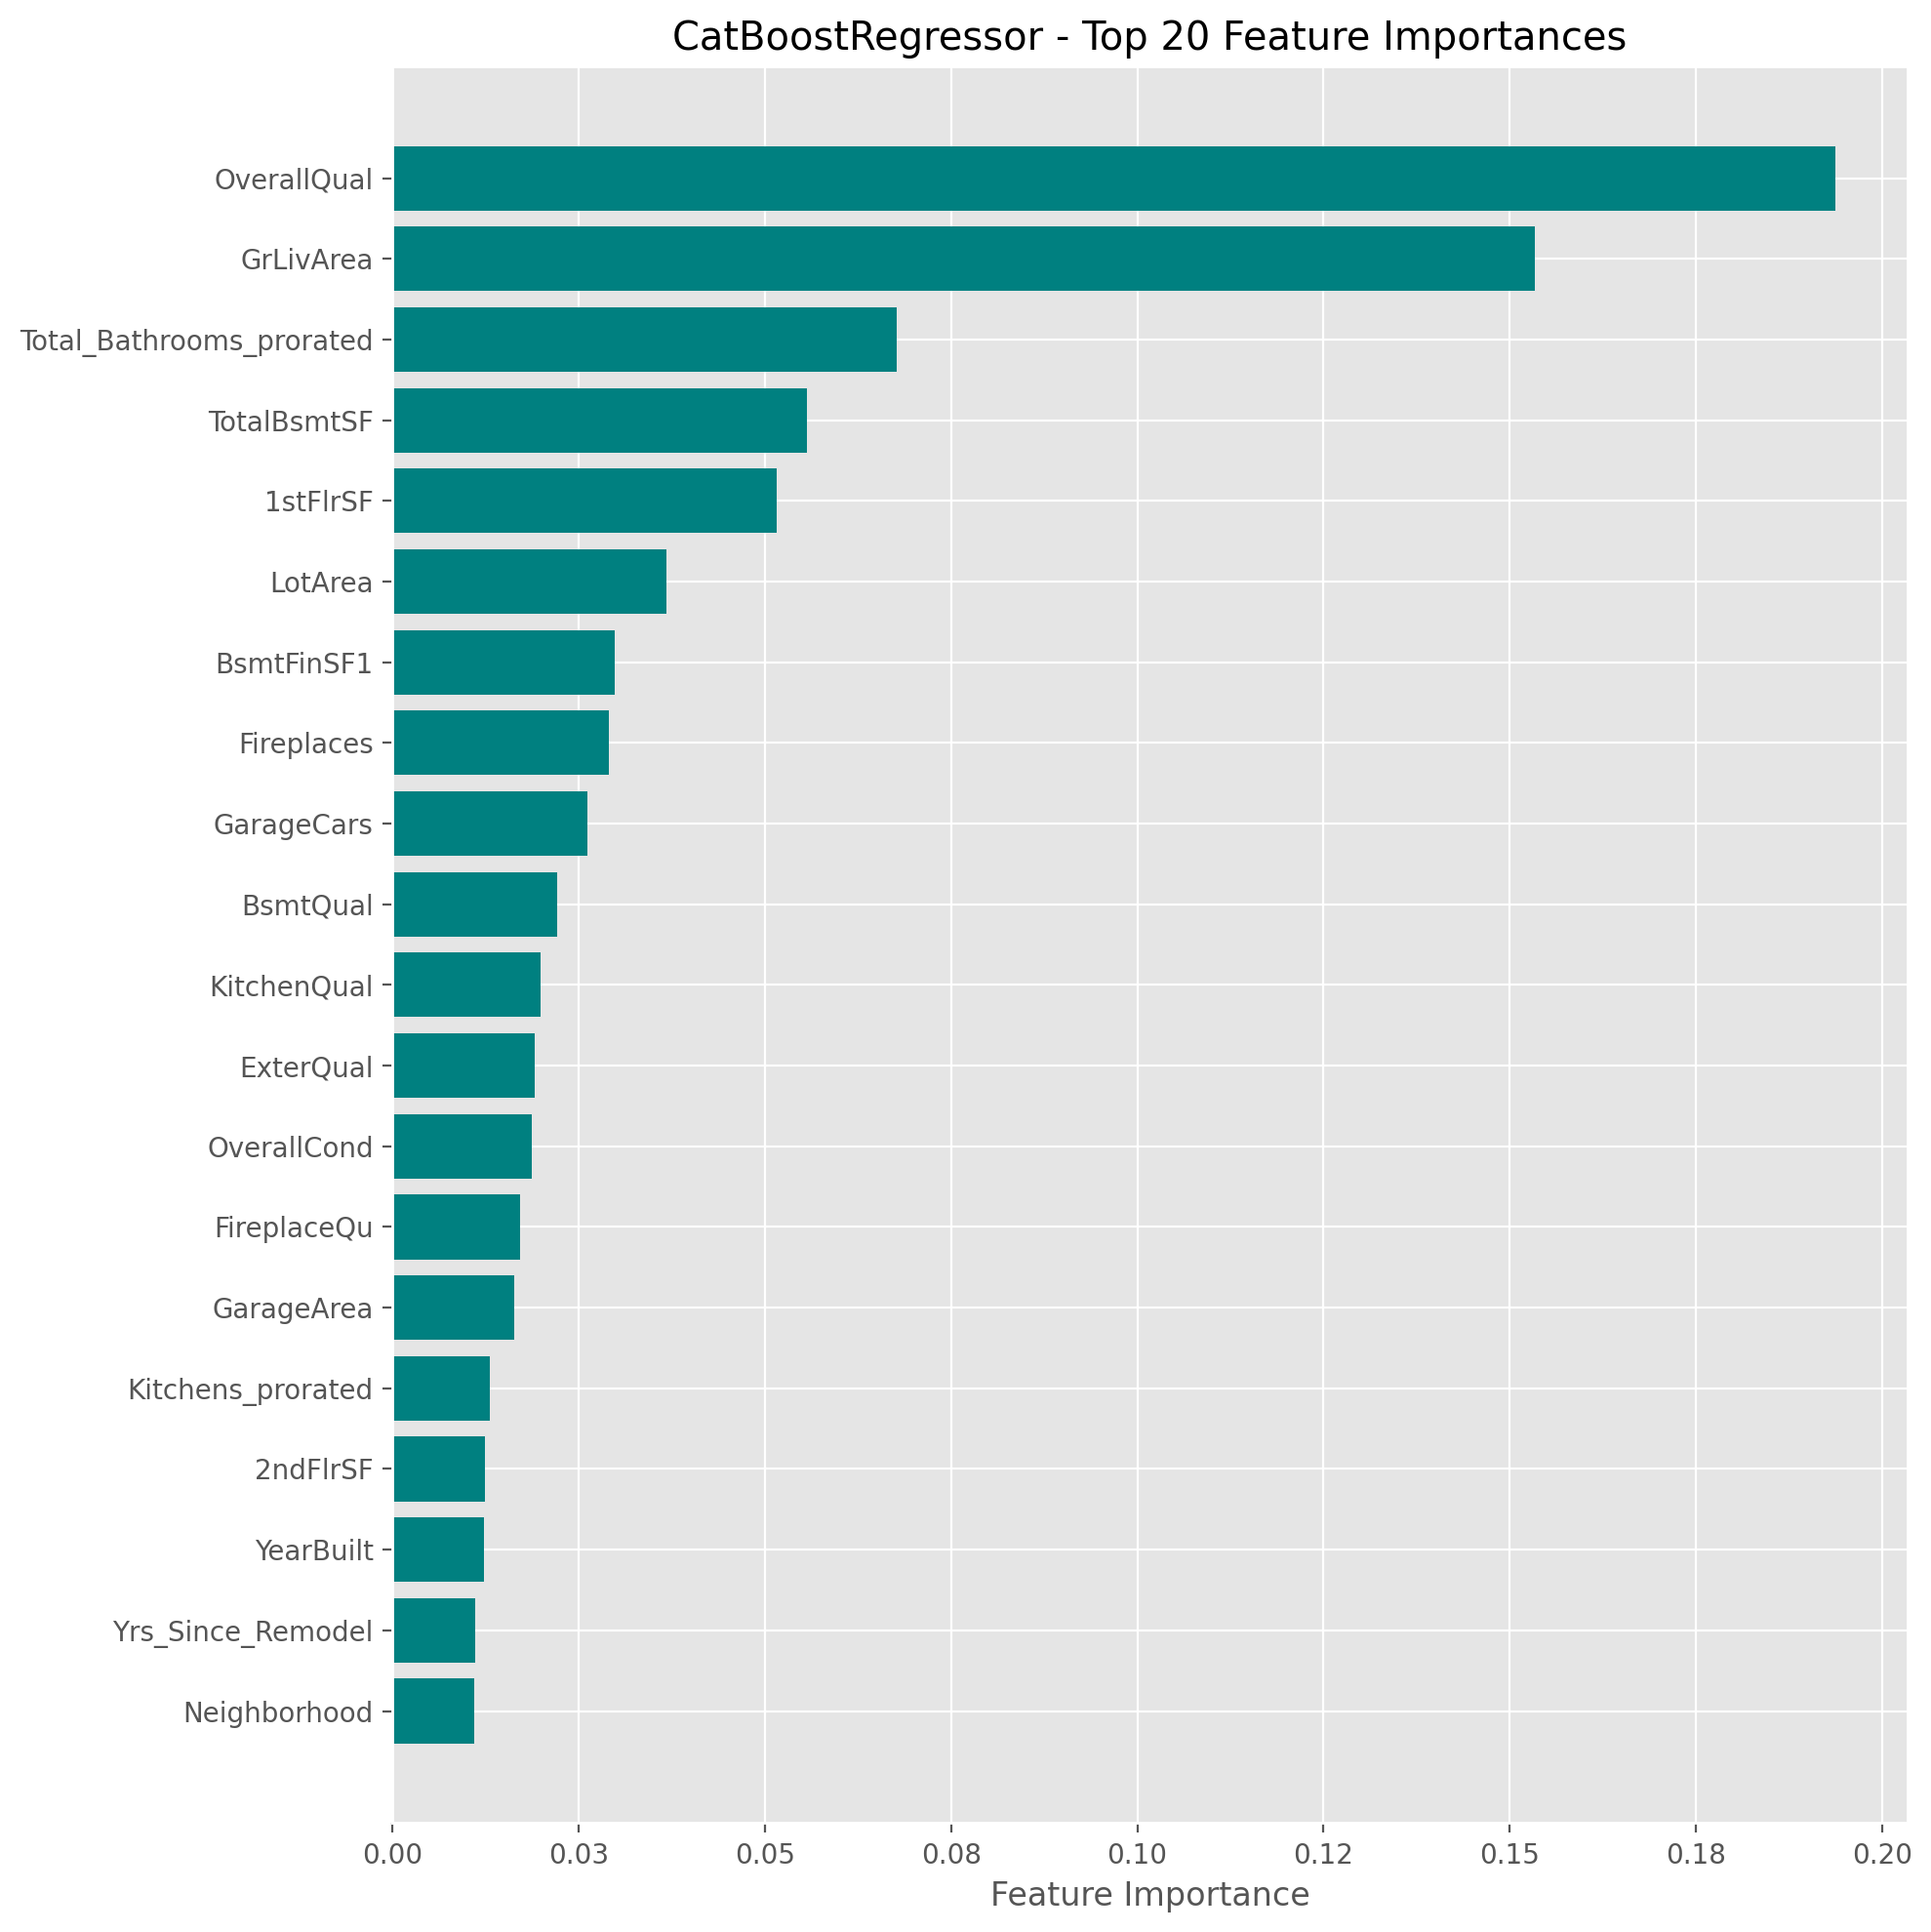

,Feature,Importance
0,OverallQual,0.1937
1,GrLivArea,0.1534
2,Total_Bathrooms_prorated,0.0677
3,TotalBsmtSF,0.0556
4,1stFlrSF,0.0516
5,LotArea,0.0368
6,BsmtFinSF1,0.0298
7,Fireplaces,0.0291
8,GarageCars,0.0262
9,BsmtQual,0.0221


In [46]:
#CatBoost Feature Importances & SHAP values
Plot_Feature_Importances_Only(cat_boost, X2)